# Regression modeling

## Author: Nika Faraji

### This notebook goes through the cycle of training and testing a model. Includes OLS regression and Randm Forest model training and testing results

In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('data/aggregated_data_renamed.csv')
df = df.sort_values(by=['state_id', 'year'])

# Add the tgt_util_rate column which is the util_rate for the state at the following year
df['tgt_util_rate'] = df.groupby('state_id')['util_rate'].shift(-1)
df

,state_id,year,anxiety_ct,PTSD_ct,ADHD_ct,bipolar_ct,depression_ct,total_service,population_est,util_rate,max_ADHD,max_PTSD,max_anxiety,max_bipolar,max_depression,max_mental hospital,max_psychiatrists near me,max_psychologist near me,max_therapist near me,tgt_util_rate
400,1,2013,14529,10242,15485,17877,30291,678407,4831586,0.140411,28,11,52,25,77,50,0,0,0,0.135877
356,1,2014,14618,9797,15268,17473,28848,658152,4843737,0.135877,29,13,54,26,78,40,0,0,0,0.145889
314,1,2015,15720,11619,16558,18553,30669,708264,4854803,0.145889,27,15,63,26,85,36,0,0,0,0.149509
271,1,2016,13406,10582,15078,12680,30570,727636,4866824,0.149509,24,15,70,28,82,40,0,0,10,0.148720
227,1,2017,13683,11256,15612,12535,29660,725455,4877989,0.148720,27,15,75,23,85,37,8,7,22,0.146167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,56,2018,4146,3893,1391,1674,5630,113785,579054,0.196502,28,18,78,25,80,0,0,0,0,0.201706
182,56,2019,4764,4024,1385,1721,5874,117013,580116,0.201706,31,22,83,21,84,0,0,0,0,0.194399
138,56,2020,4636,3860,1321,1671,5861,113204,582328,0.194399,29,18,79,21,82,0,0,60,81,0.171900
91,56,2021,4421,3476,1158,1571,5176,99613,579483,0.171900,42,20,79,32,65,0,0,0,79,0.169459


In [2]:
#Custom funtion to add features missing in dataset
def add_previous_year_features(df, feature_cols):
    # Sort the DataFrame by state_id and year
    df = df.sort_values(by=['state_id', 'year'])
    
    # Add the previous year's util rate
    df['prev_util_rate'] = df.groupby('state_id')['util_rate'].shift(1)
    
    # List to store new feature columns
    new_feature_cols = ['prev_util_rate']
    
    # Add the previous year's values for each feature column
    for col in feature_cols:
        new_col = f'prev_{col}'
        df[new_col] = df.groupby('state_id')[col].shift(1)
        new_feature_cols.append(new_col)
    
    return df, new_feature_cols

In [3]:
feature_cols = [
    "max_ADHD", "max_PTSD", "max_anxiety", "max_bipolar", "max_depression",
     "max_mental hospital", "max_psychiatrists near me", "max_psychologist near me", "max_therapist near me",
]

df, feature_cols = add_previous_year_features(df, feature_cols)

df = df.groupby('state_id').apply(lambda group: group.iloc[1:-1]).reset_index(drop=True)

# Drop rows where `tgt_util_rate` is Empty
df = df.dropna(subset=['util_rate', 'tgt_util_rate'])


# Split the data into training and testing sets based on the values from Professors formula
X = df[feature_cols]
y = df['tgt_util_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [114]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 0.00
R² Score: 0.91


In [115]:
print("Variance of target (util_rate):", y.var())

Variance of target (util_rate): 0.01642346333288608


In [5]:
from sklearn.ensemble import RandomForestRegressor

#Random Forest Regression 
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)


#make predictions
y_pred = regressor.predict(X_test)

# out-of-bag score
oob_score = regressor.oob_score_

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Out-of-Bag Score: {oob_score}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.8474343973501346
Mean Squared Error: 0.003198237785729331
R-squared: 0.838367078141548


C:\Users\farajin1\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [6]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [7]:
# Train Random Forest with tuned hyperparameters
rf = RandomForestRegressor(
    n_estimators=100,        # Number of trees
    max_depth=15,            # Limit depth of trees
    min_samples_split=2,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples in a leaf node
    max_features='sqrt',     # Number of features to consider for each split
    random_state=42,         # Ensures reproducibility
    oob_score=True           # Enables OOB score
)

rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R²: {r2}")
print(f"OOB Score: {rf.oob_score_}")

Test MSE: 0.0042398359076673536
Test R²: 0.7857266682876176
OOB Score: 0.8146809143402987


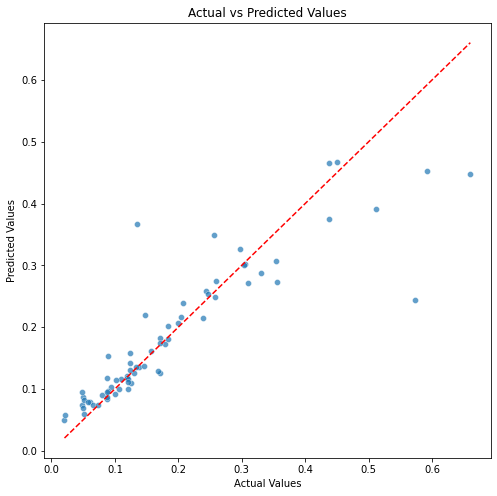

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Predicted
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ideal fit line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


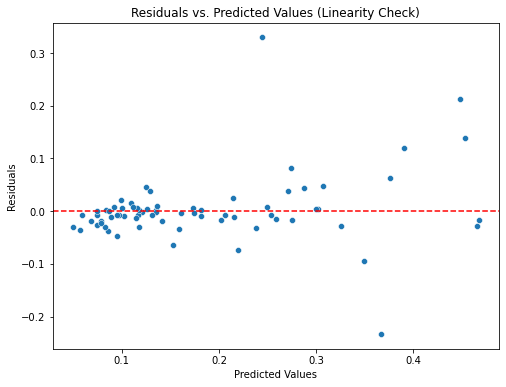

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Linearity Check)")
plt.show()


In [8]:
from statsmodels.stats.stattools import durbin_watson

# Perform Durbin-Watson test
dw_stat = durbin_watson(residuals)
dw_stat

# ~2: No autocorrelation
# <2: Positive autocorrelation
# >2: Negative autocorrelation

Durbin-Watson Statistic: 1.7387121182458511


In [9]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Breusch-Pagan test for equal variance
exog = sm.add_constant(X_test)  
bp_test = het_breuschpagan(residuals, exog)
bp_test[1]  #second val is the p-value

# Interpretation:
# p-value > 0.05: Homoscedasticity (good)
# p-value <= 0.05: Heteroscedasticity


Breusch-Pagan p-value: 0.4144604455956435


C:\Users\farajin1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


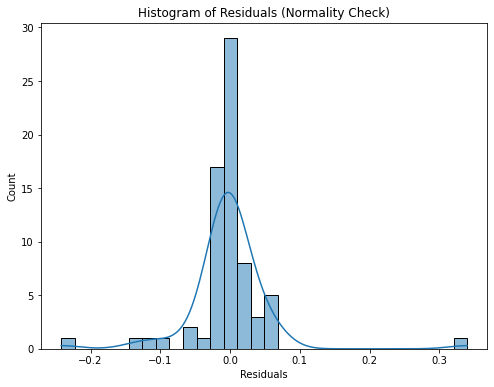

C:\Users\farajin1\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


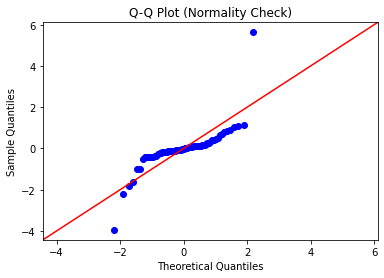

Shapiro-Wilk p-value: 5.311703160648662e-11


In [11]:
from scipy.stats import shapiro
import numpy as np

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals (Normality Check)")
plt.xlabel("Residuals")
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot (Normality Check)")
plt.show()

# Shapiro-Wilk test
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)
# Interpretation:
# p-value > 0.05: Residuals are normally distributed (good)
# p-value <= 0.05: Residuals deviate from normality


In [119]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
# Interpretation:
# VIF < 5: Low multicollinearity (good)
# VIF > 5: Moderate to high multicollinearity
# VIF > 10: Very high multicollinearity (problematic)


                          Feature         VIF
0                  prev_util_rate    4.131146
1                   prev_max_ADHD   86.135466
2                   prev_max_PTSD   53.826226
3                prev_max_anxiety  122.016968
4                prev_max_bipolar   90.719755
5             prev_max_depression  150.929174
6        prev_max_mental hospital    8.107935
7  prev_max_psychiatrists near me    1.225824
8   prev_max_psychologist near me    2.995910
9      prev_max_therapist near me    5.277455
